In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import UnivariateSpline
from scipy.stats import gaussian_kde, sem
from matplotlib.patches import Circle
from matplotlib.colors import to_rgb
from sklearn.linear_model import LinearRegression
from my_utils import *

from pathlib import Path
import sys
import warnings

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

arg = config.ConfigGain()
arg.device = 'cpu'

In [3]:
# monkey data path
monkey_data_path = Path('../data/monkey_data')
# agents checkpoints path
progress_agents_path = Path('../data/agents')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure4')

# Load monkey data

In [4]:
data_path = monkey_data_path / 'Bruno'
bruno_normal_trajectory = pd.read_pickle(data_path / 'bruno_normal_trajectory_paper.pkl')
bruno_normal_trajectory_all = deepcopy_pd(bruno_normal_trajectory, is_df=True)
bruno_gain_trajectory = pd.read_pickle(data_path / 'bruno_gain_trajectory_paper.pkl')
bruno_gain_trajectory_all = deepcopy_pd(bruno_gain_trajectory, is_df=True)

data_path = monkey_data_path / 'Schro'
schro_normal_trajectory = pd.read_pickle(data_path / 'schro_normal_trajectory_paper.pkl')
schro_normal_trajectory_all = deepcopy_pd(schro_normal_trajectory, is_df=True)
schro_gain_trajectory = pd.read_pickle(data_path / 'schro_gain_trajectory_paper.pkl')
schro_gain_trajectory_all = deepcopy_pd(schro_gain_trajectory, is_df=True)

In [5]:
# Match monkey trials by target positions
EPISODE_SIZE = 1000
bruno_normal_trajectory, schro_normal_trajectory = match_similar_trials(bruno_normal_trajectory, 
                                                                        schro_normal_trajectory, 
                                                                        is_sort=True, EPISODE_SIZE=EPISODE_SIZE)
bruno_gain_trajectories = [bruno_normal_trajectory] + \
                          [match_similar_trials(bruno_gain_trajectory[bruno_gain_trajectory.gain_v == gain_v], 
                                                bruno_normal_trajectory) 
                           for gain_v in bruno_gain_trajectory.gain_v.unique()]
schro_gain_trajectories = [schro_normal_trajectory] + \
                          [match_similar_trials(schro_gain_trajectory[schro_gain_trajectory.gain_v == gain_v], 
                                                schro_normal_trajectory) 
                           for gain_v in schro_gain_trajectory.gain_v.unique()]

In [6]:
# Simulate no generalization cases
monkey_names = ['bruno', 'schro']

for monk_name in monkey_names:
    for idx, gain_df in enumerate(eval(f'{monk_name}_gain_trajectories')):
        normal_df = match_similar_trials(eval(f'{monk_name}_normal_trajectory_all'), gain_df, replace=True)
        locals()[f'{monk_name}_gain_trajectories'][idx] = simulate_no_generalization(gain_df, 
                                                                                     normal_df, subject='monkey')

# Select agent checkpoints for analyses

In [7]:
def select_agents(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain'):
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).episode > 0) & (pd.read_csv(file).episode < MAX_TRAINING_T)] 
                      for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
                     for agent_arch in agent_archs]
    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    best_seeds = [seed[np.argmax([np.sum([file[file.task == task].reward_rate 
                                          for task in file.task.unique()], axis=0).max()
                                  for file in perform_file])] 
                  for perform_file, seed in zip(perform_files, seeds)]
    best_files_idx = [np.argmax([np.sum([file[file.task == task].reward_rate 
                                         for task in file.task.unique()], axis=0).max()
                                 for file in perform_file]) 
                      for perform_file in perform_files]
    
    best_paths = [progress_agents_path / agent_arch / task / f'seed{seed}'
                  for agent_arch, seed in zip(agent_archs, best_seeds)]
    
    best_files = [perform_file[file_idx] for perform_file, file_idx in zip(perform_files, best_files_idx)]
    best_episodes = [file.episode.unique()[np.sum([file[file.task == task].reward_rate 
                                                   for task in file.task.unique()], axis=0).argmax()] 
                     for file in best_files]

    best_agents = [list(best_path.glob(f'*-{best_episode}.*'))[0].stem.split('.')[0]
                   for best_path, best_episode in zip(best_paths, best_episodes)]
    
    return best_seeds, best_paths, best_agents, perform_files

In [8]:
Models = {'Holistic_Actor': 'Actor1', 'Holistic_Critic': 'Critic1',
          'Modular_Actor': 'Actor3', 'Modular_Critic': 'Critic5'}
for k, v in Models.items():
    exec(f'from {v} import {v[:-1]} as {k}')

agent_archs = [Models['Holistic_Actor'] + Models['Holistic_Critic'], 
               Models['Modular_Actor'] + Models['Holistic_Critic'],
               Models['Holistic_Actor'] + Models['Modular_Critic'],
               Models['Modular_Actor'] + Models['Modular_Critic']]

MAX_TRAINING_T = 1e4
task = 'gain'

In [9]:
best_seeds, best_paths, best_agents, perform_files = select_agents(progress_agents_path, 
                                                                   agent_archs, 
                                                                   MAX_TRAINING_T=MAX_TRAINING_T,
                                                                   task=task)

In [10]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain'):    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}_*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                      for task in perform_file.task.unique()], axis=0).argmax()]
            
            agent_path.append(progress_agents_path / agent_arch / task / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files

In [11]:
agent_paths, agent_files = select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain')

# Run agents

In [12]:
from Agent_RNN import *
from Environment import Env

In [13]:
def RNN_agent_simulation(agent, target_positions, gains, arg):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []; pos_theta = []; pos_r_end = []; pos_theta_end = []; 
    pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []

    for target_position, gain in zip(target_positions, gains):
        cross_start_threshold = False
        x = env.reset(target_position=target_position, pro_gains=gain)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

            if is_stop and cross_start_threshold:
                break

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(torch.cat(states))

        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range
    
    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, gain_v=torch.stack(gains)[:, 0].numpy(),
                                 gain_w=torch.stack(gains)[:, 1].numpy(), 
                                 state=state_, action=action_))

In [14]:
holistic_idx = 0
filename_holistic, arg.holistic_SEED_NUMBER = best_agents[holistic_idx], int(best_seeds[holistic_idx])
holistic_agent = Agent(arg, Holistic_Actor, Holistic_Critic)
holistic_agent.data_path = best_paths[holistic_idx]
holistic_agent.load(filename_holistic, load_memory=False, load_optimzer=False)

moho_idx = 1
filename_moho = best_agents[moho_idx]
moho_agent = Agent(arg, Modular_Actor, Holistic_Critic)
moho_agent.data_path = best_paths[moho_idx]
moho_agent.load(filename_moho, load_memory=False, load_optimzer=False)

homo_idx = 2
filename_homo = best_agents[homo_idx]
homo_agent = Agent(arg, Holistic_Actor, Modular_Critic)
homo_agent.data_path = best_paths[homo_idx]
homo_agent.load(filename_homo, load_memory=False, load_optimzer=False)

modular_idx = 3
filename_modular, arg.SEED_NUMBER = best_agents[modular_idx], int(best_seeds[modular_idx])
modular_agent = Agent(arg, Modular_Actor, Modular_Critic)
modular_agent.data_path = best_paths[modular_idx]
modular_agent.load(filename_modular, load_memory=False, load_optimzer=False)

In [15]:
target_positions = torch.tensor(bruno_normal_trajectory[['target_x', 'target_y']].values.T, 
                                dtype=torch.float32) / arg.LINEAR_SCALE
target_positions = torch.chunk(target_positions, len(bruno_normal_trajectory), dim=1)
    
modular_gain_trajectories = []; holistic_gain_trajectories = []
moho_gain_trajectories = []; homo_gain_trajectories = []
for gain in [1, 1.5, 2]:
    gains = [gain * arg.process_gain_default] * len(target_positions)
    modular_gain_trajectories.append(RNN_agent_simulation(modular_agent, target_positions, gains, arg))
    holistic_gain_trajectories.append(RNN_agent_simulation(holistic_agent, target_positions, gains, arg))
    moho_gain_trajectories.append(RNN_agent_simulation(moho_agent, target_positions, gains, arg))
    homo_gain_trajectories.append(RNN_agent_simulation(homo_agent, target_positions, gains, arg))
    
modular_normal_trajectory = modular_gain_trajectories[0]
holistic_normal_trajectory = holistic_gain_trajectories[0]
moho_normal_trajectory = moho_gain_trajectories[0]
homo_normal_trajectory = homo_gain_trajectories[0]

In [16]:
for (idx, mo_gain_df), ho_gain_df, moho_gain_df, homo_gain_df in zip(enumerate(modular_gain_trajectories), 
                                    holistic_gain_trajectories, moho_gain_trajectories, homo_gain_trajectories):
    modular_gain_trajectories[idx] = simulate_no_generalization(mo_gain_df, modular_normal_trajectory, 
                                                                subject='agent')
    holistic_gain_trajectories[idx] = simulate_no_generalization(ho_gain_df, holistic_normal_trajectory, 
                                                                 subject='agent')
    moho_gain_trajectories[idx] = simulate_no_generalization(moho_gain_df, moho_normal_trajectory, 
                                                                subject='agent')
    homo_gain_trajectories[idx] = simulate_no_generalization(homo_gain_df, homo_normal_trajectory, 
                                                                 subject='agent')

In [17]:
modular_agents = []
for agent_path, agent_file in zip(agent_paths[modular_idx], agent_files[modular_idx]):
    modular_agent_ = Agent(arg, Modular_Actor, Modular_Critic)
    modular_agent_.data_path = agent_path
    modular_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    modular_agents.append(modular_agent_)
    
holistic_agents = []
for agent_path, agent_file in zip(agent_paths[holistic_idx], agent_files[holistic_idx]):
    holistic_agent_ = Agent(arg, Holistic_Actor, Holistic_Critic)
    holistic_agent_.data_path = agent_path
    holistic_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    holistic_agents.append(holistic_agent_)
    
moho_agents = []
for agent_path, agent_file in zip(agent_paths[moho_idx], agent_files[moho_idx]):
    moho_agent_ = Agent(arg, Modular_Actor, Holistic_Critic)
    moho_agent_.data_path = agent_path
    moho_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    moho_agents.append(moho_agent_)
    
homo_agents = []
for agent_path, agent_file in zip(agent_paths[homo_idx], agent_files[homo_idx]):
    homo_agent_ = Agent(arg, Holistic_Actor, Modular_Critic)
    homo_agent_.data_path = agent_path
    homo_agent_.load(agent_file, load_memory=False, load_optimzer=False)
    homo_agents.append(homo_agent_)

In [18]:
modular_gain_trajectories_all = []; holistic_gain_trajectories_all = []
moho_gain_trajectories_all = []; homo_gain_trajectories_all = []
for gain in [1, 1.5, 2]:
    gains = [gain * arg.process_gain_default] * len(target_positions)
    modular_gain_trajectories_all.append(list(map(RNN_agent_simulation, modular_agents, 
                                                  [target_positions] * len(modular_agents), 
                                                  [gains] * len(modular_agents), [arg] * len(modular_agents))))
    holistic_gain_trajectories_all.append(list(map(RNN_agent_simulation, holistic_agents, 
                                                   [target_positions] * len(holistic_agents), 
                                                   [gains] * len(holistic_agents), [arg] * len(holistic_agents))))
    moho_gain_trajectories_all.append(list(map(RNN_agent_simulation, moho_agents, 
                                               [target_positions] * len(moho_agents), 
                                               [gains] * len(moho_agents), [arg] * len(moho_agents))))
    homo_gain_trajectories_all.append(list(map(RNN_agent_simulation, homo_agents, 
                                               [target_positions] * len(homo_agents), 
                                               [gains] * len(homo_agents), [arg] * len(homo_agents))))

In [19]:
for (idx, mo_gain_dfs), ho_gain_dfs, moho_gain_dfs, homo_gain_dfs in zip(enumerate(modular_gain_trajectories_all), 
                        holistic_gain_trajectories_all, moho_gain_trajectories_all, homo_gain_trajectories_all):
    for (iidx, mo_gain_df), ho_gain_df, moho_gain_df, homo_gain_df in zip(enumerate(mo_gain_dfs), ho_gain_dfs,
                                                                          moho_gain_dfs, homo_gain_dfs):
        modular_gain_trajectories_all[idx][iidx] = simulate_no_generalization(mo_gain_df, 
                                                                              modular_gain_trajectories_all[0][iidx], 
                                                                              subject='agent')
        holistic_gain_trajectories_all[idx][iidx] = simulate_no_generalization(ho_gain_df, 
                                                                               holistic_gain_trajectories_all[0][iidx], 
                                                                               subject='agent')
        moho_gain_trajectories_all[idx][iidx] = simulate_no_generalization(moho_gain_df, 
                                                                           moho_gain_trajectories_all[0][iidx], 
                                                                           subject='agent')
        homo_gain_trajectories_all[idx][iidx] = simulate_no_generalization(homo_gain_df, 
                                                                           homo_gain_trajectories_all[0][iidx], 
                                                                           subject='agent')

# Figures

In [20]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

## 4a

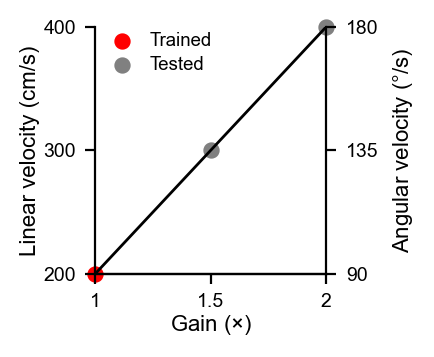

In [21]:
width = 2.1; height = 1.6

gains = np.array([1, 1.5, 2])
v_lin = arg.process_gain_default[0].item() * gains * arg.LINEAR_SCALE
v_ang = np.round(np.rad2deg(arg.process_gain_default[1].item() * gains))

with initiate_plot(width, height, 200) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(gains, fontsize=fontsize)
    plt.yticks(v_lin, fontsize=fontsize)
    ax.set_xlabel(r'Gain ($\times$)', fontsize=fontsize + 1)
    ax.set_ylabel(r'Linear velocity (cm/s)', fontsize=fontsize + 1)
    ax.set_xlim([gains[0], gains[-1]])
    ax.set_ylim([v_lin[0], v_lin[-1]])
    ax.xaxis.set_label_coords(0.5, -0.16)
    ax.yaxis.set_label_coords(-0.24, 0.5)
    ax.xaxis.set_major_formatter(major_formatter)
    
    training_gains = 1; monk_gains = np.array([1.5, 2])
    l1 = ax.scatter(training_gains, arg.process_gain_default[0].item() * training_gains * arg.LINEAR_SCALE, 
                    lw=lw * 2, c='r', clip_on=False, s=15, label='Trained')
    l2 = ax.scatter(monk_gains, arg.process_gain_default[0].item() * monk_gains * arg.LINEAR_SCALE, 
                    lw=lw * 2, c='gray', clip_on=False, s=15, label='Tested')
    
    
    bar3 = ax.bar(0, 0, color='none', hatch='\\' * 4)
    ax.plot(gains, v_lin, c='k', lw=lw)
    
    axt = ax.twinx()
    axt.spines['top'].set_visible(False); axt.spines['left'].set_visible(False)
    plt.yticks(v_ang, fontsize=fontsize)
    axt.set_ylabel(r'Angular velocity ($\degree$/s)', fontsize=fontsize + 1)
    axt.set_ylim([v_ang[0], v_ang[-1]])
            
    ax.legend(fontsize=fontsize - 0.3, frameon=False, loc=[0, 0.78], 
              handletextpad=0.5, labelspacing=0.3, ncol=1, columnspacing=0.5)
    
    fig.tight_layout(pad=0.05)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='gain_illustration'), orientation='portrait', format='pdf', transparent=True)

## 4b

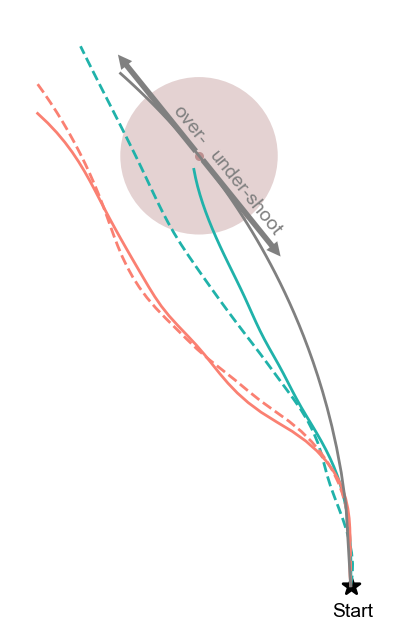

In [22]:
p_idx = 87
width = 2.8
height = 3

dfs = [modular_gain_trajectories[1], holistic_gain_trajectories_all[1][4]]
modular_trial, holistic_trial = [df.iloc[p_idx] for df in dfs]

with initiate_plot(width, height, 200) as fig, warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
    
    # modular agent
    mx = modular_trial.pos_x; my = modular_trial.pos_y; mf = UnivariateSpline(my, mx)
    my_new = np.linspace(my[0], my[-1], endpoint=True)
    ax.plot(mf(my_new), my_new, lw=lw, c=modular_c)
    mx_ = modular_trial.sim_pos_x; my_ = modular_trial.sim_pos_y; mf_ = UnivariateSpline(my_, mx_)
    my_new_ = np.linspace(my_[0], my_[-1], endpoint=True)
    ax.plot(mf_(my_new_), my_new_, lw=lw, c=modular_c, ls='--')
    
    # holistic agent
    hx = holistic_trial.pos_x; hy = holistic_trial.pos_y; hf = UnivariateSpline(hy, hx)
    hy_new = np.linspace(hy[0], hy[-1], endpoint=True)
    ax.plot(hf(hy_new), hy_new, lw=lw, c=holistic_c)
    hx_ = holistic_trial.sim_pos_x; hy_ = holistic_trial.sim_pos_y; hf_ = UnivariateSpline(hy_, hx_)
    hy_new_ = np.linspace(hy_[0], hy_[-1], endpoint=True)
    ax.plot(hf_(hy_new_), hy_new_, lw=lw, c=holistic_c, ls='--')
    
    ax.plot([], [], lw=lw, c='k', label='Data')
    ax.plot([], [], lw=lw, c='k', ls='--', label='No generalization')
    
    # target position
    target_x = modular_trial.target_x; target_y = modular_trial.target_y
    cir1 = Circle(xy=[target_x, target_y], 
                  radius=arg.goal_radius_range[0] * arg.LINEAR_SCALE, 
                  alpha=0.4, color=reward_c, lw=0)
    ax.add_patch(cir1)
    ax.scatter(target_x, target_y, c=reward_c, s=5)
    
    # plot initial position
    ax.scatter(0, 0, c='k', s=40, marker='*')
    ax.text(-15, -25, s='Start', fontsize=fontsize)
    
    
    x = np.linspace(target_x * 0.4, target_x * 1.7)
    k = (2 * target_x * target_y) / (target_x**2 - target_y**2)
    k = -1 / k; b = 200
    
    start_x = -125; end_x1 = start_x + 70; end_x2 = start_x -70
    ax.annotate("", xytext=(start_x, k * start_x + b), xy=(end_x1, k * end_x1 + b),
                arrowprops=dict(arrowstyle="simple", lw=0.01, color='gray'))
    ax.annotate("", xytext=(start_x, k * start_x + b), xy=(end_x2, k * end_x2 + b),
                arrowprops=dict(arrowstyle="simple", lw=0.01, color='gray'))
    
    ax.text(start_x + 5, 290, s='under-shoot', c='gray', 
            rotation=np.rad2deg(np.arctan(k)), fontsize=fontsize)
    ax.text(start_x - 25, 365, s='over-', c='gray', 
            rotation=np.rad2deg(np.arctan(k)), fontsize=fontsize)
    
    x = np.linspace(0, -190)
    k = (target_x**2 + target_y**2) / (2 * target_x)
    y = np.sqrt(k**2 - (x-k)**2); y[0] = 0
    plt.plot(x, y, c='gray', lw=lw)
    
    fig.tight_layout(pad=0)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='trial_example'), orientation='portrait', format='pdf', transparent=True)

## 4g

In [23]:
mean_reward_rate = [np.vstack([np.mean([file[file.task == task].reward_rate 
                                        for task in file.task.unique() if task != 'gain1x'], axis=0)
                               for file in perform_file]).mean(axis=0) 
                    for perform_file in perform_files]
sem_reward_rate = [sem(np.vstack([np.mean([file[file.task == task].reward_rate 
                                           for task in file.task.unique() if task != 'gain1x'], 
                                          axis=0) 
                                  for file in perform_file]), axis=0) 
                   for perform_file in perform_files]
mean_reward_1x = [np.vstack([file[file.task == 'gain1x'].reward_fraction for file in perform_file]).mean(axis=0) 
                  for perform_file in perform_files]

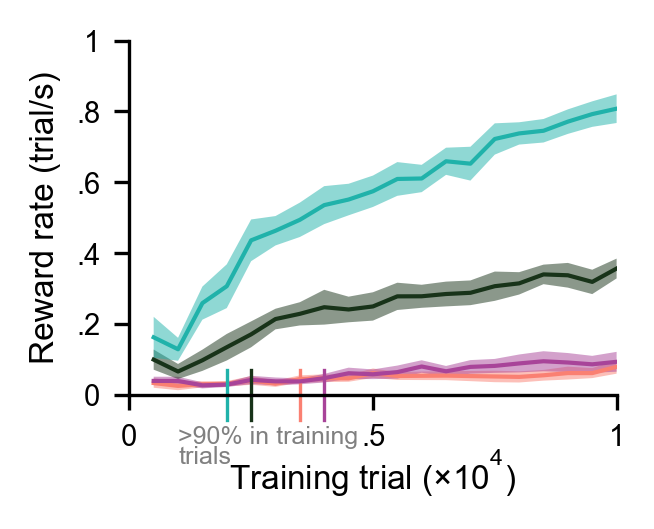

In [24]:
width = 2; height = 1.6

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = np.array([0, MAX_TRAINING_T / 2, MAX_TRAINING_T])
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.14, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode.unique()
    for ymean, ystd, y1x, color in zip(mean_reward_rate, sem_reward_rate, mean_reward_1x,
                                       [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]):
        ax.plot(xdata, ymean, lw=lw, clip_on=True, c=color)
        ax.fill_between(xdata, ymean - ystd, ymean + ystd,
                        edgecolor='None', facecolor=color, alpha=0.5)
        ax.plot([xdata[np.where(y1x > 0.9)[0][0]]] * 2, [0.07, -0.07], lw=lw * 0.8, c=color, 
                ls='-', clip_on=False)
    
    ax.text(1e3, -0.195, '>90% in training\ntrials', fontsize=fontsize - 1, linespacing=0.85, c='gray')
    
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='training_perform'), orientation='portrait', format='pdf', transparent=True)

## 4h

In [25]:
mean_td_abs = [np.vstack([np.mean([file[file.task == task].TD_error_abs
                                   for task in file.task.unique() if task != 'gain1x'], axis=0)
                          for file in perform_file]).mean(axis=0) 
               for perform_file in perform_files]
sem_td_abs = [sem(np.vstack([np.mean([file[file.task == task].TD_error_abs 
                                      for task in file.task.unique() if task != 'gain1x'], axis=0) 
                             for file in perform_file]), axis=0) 
              for perform_file in perform_files]

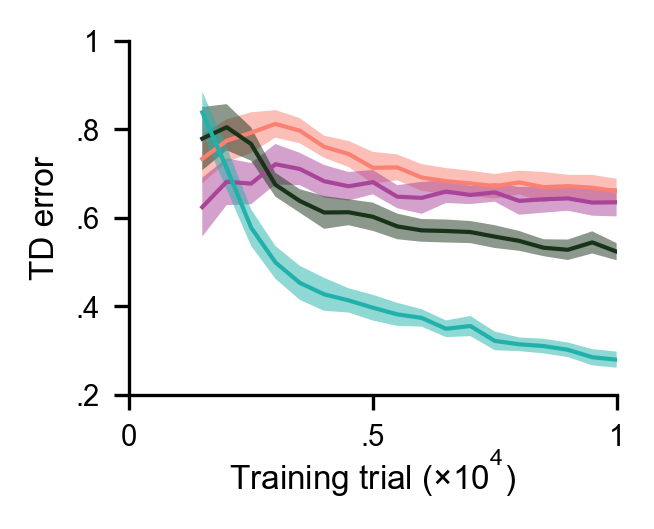

In [26]:
width = 2; height = 1.6

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0.2, 1, 5), 1)
xticks = np.array([0, MAX_TRAINING_T / 2, MAX_TRAINING_T])
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
    ax.set_ylabel('TD error', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.14, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xdata = perform_files[0][0].episode.unique()
    for ymean, ystd, y1x, color in zip(mean_td_abs, sem_td_abs, mean_reward_1x, 
                                       [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]):
        start_idx = np.where(y1x > 0.6)[0][0]
        ax.plot(xdata[start_idx:], ymean[start_idx:], lw=lw, clip_on=True, c=color)
        ax.fill_between(xdata[start_idx:], (ymean - ystd)[start_idx:], (ymean + ystd)[start_idx:],
                        edgecolor='None', facecolor=color, alpha=0.5)
    
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='training_perform2'), orientation='portrait', format='pdf', transparent=True)

## 4d

In [27]:
dfs = [bruno_gain_trajectories, schro_gain_trajectories]
dfs = repeat_element(*dfs)

is_sims = [False, True] * int(len(dfs) / 2)
_ = list(map(get_radial_error, dfs, is_sims))

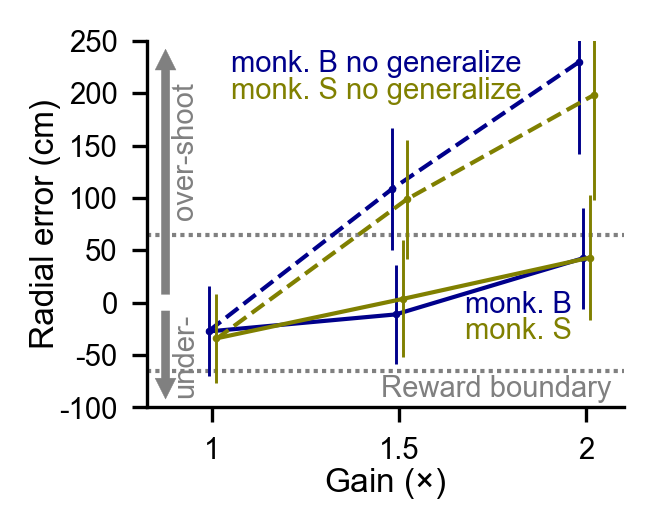

In [28]:
width = 2; height = 1.6
marker = '.'; marker_size = 5; marker_lw = lw * 0.7

xticklabels = [1, 1.5, 2]
xticks = np.arange(len(xticklabels))
yticks = np.arange(-100, 251, 50)
target_radius = arg.goal_radius_range[0] * 400

colors = [monkB_c, monkS_c]
dfs = [bruno_gain_trajectories, schro_gain_trajectories]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Gain ($\times$)', fontsize=fontsize + 1)
    ax.set_ylabel(r'Radial error (cm)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.35, xticks[-1] + 0.2)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.16)
    ax.yaxis.set_label_coords(-0.18, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xshifts = [-0.02, 0.02]
    for agent_idx, dfs_ in enumerate(dfs):
        xdata = xticks + xshifts[agent_idx]
        ymean = np.vstack([df.relative_radius_end_shoot for df in dfs_]).mean(axis=1)
        ystd = np.std(np.vstack([df.relative_radius_end_shoot for df in dfs_]), axis=1)
        ax.scatter(xdata, ymean, c=colors[agent_idx], s=marker_size, lw=marker_lw, marker=marker)
        ax.plot(xdata, ymean, c=colors[agent_idx], lw=lw)
        ax.errorbar(xdata, ymean, ystd, c=colors[agent_idx], lw=marker_lw, ls='none')
        
        xdata = np.hstack([xdata[0], xticks[1:] + xshifts[agent_idx] * 2])
        ymean = np.vstack([df.sim_relative_radius_end_shoot for df in dfs_]).mean(axis=1)
        ystd = np.std(np.vstack([df.sim_relative_radius_end_shoot for df in dfs_]), axis=1)
        ax.scatter(xdata[1:], ymean[1:], c=colors[agent_idx], s=marker_size, lw=marker_lw, marker=marker)
        ax.plot(xdata, ymean, c=colors[agent_idx], lw=lw, ls='--')
        ax.errorbar(xdata[1:], ymean[1:], ystd[1:], c=colors[agent_idx], lw=marker_lw, ls='none')
        
    ax.plot(np.linspace(*ax.get_xlim()), np.linspace(target_radius, target_radius), 
            ls=(0, (1, 1)), c='gray', lw=lw, zorder=-1)
    ax.plot(np.linspace(*ax.get_xlim()), -np.linspace(target_radius, target_radius), 
            ls=(0, (1, 1)), c='gray', lw=lw, zorder=-1)
    
    arrow_x = 0.25
    ax.annotate("", xytext=(-arrow_x, 0), xy=(-arrow_x, ax.get_ylim()[0]),
                arrowprops=dict(arrowstyle="simple", lw=0.1, color='gray'))
    ax.annotate("", xytext=(-arrow_x, 0), xy=(-arrow_x, ax.get_ylim()[1]),
                arrowprops=dict(arrowstyle="simple", lw=0.1, color='gray'))
    ax.text(-arrow_x + 0.03, -85, s='under-', c='gray', rotation=90, fontsize=fontsize)
    ax.text(-arrow_x + 0.03, 85, s='over-shoot', c='gray', rotation=90, fontsize=fontsize)
    
    ax.text(1.35, -10, 'monk. B', c=monkB_c, fontsize=fontsize)
    ax.text(1.35, -35, 'monk. S', c=monkS_c, fontsize=fontsize)
    ax.text(0.1, 220, 'monk. B no generalize', c=monkB_c, fontsize=fontsize)
    ax.text(0.1, 195, 'monk. S no generalize', c=monkS_c, fontsize=fontsize)
    ax.text(0.9, -90, 'Reward boundary', c='gray', fontsize=fontsize)
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='monkey_error'), orientation='portrait', format='pdf', transparent=True) 

## 4c

In [29]:
def get_radial_error(dfs, is_sim=False, copyindf=True):
    if not isinstance(dfs, list):
        dfs = [dfs]
        
    errors = []
    rel_r_key = 'relative_radius_end'
    x_key = 'pos_x'; y_key = 'pos_y'
    
    if is_sim:
        rel_r_key, x_key, y_key = ['sim_' + key for key in [rel_r_key, x_key, y_key]]
        
    for df in dfs:        
        d1 = np.sqrt(df.target_x ** 2 + df.target_y ** 2)
        r1 = (df.target_x ** 2 + df.target_y ** 2) / (2 * df.target_x)
        radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))
        
        x_end = np.array([x[-1] for x in df[x_key]]); y_end = np.array([y[-1] for y in df[y_key]])
        d2 = np.sqrt(x_end ** 2 + y_end ** 2)
        r2 = (x_end ** 2 + y_end ** 2) / (2 * x_end + 1e-8)
        radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))
        
        undershoot = radian2 < radian1
        error = df[rel_r_key].copy()
        error[undershoot] = - error[undershoot]
        errors.append(error.values)
        if copyindf:
            if is_sim:
                df['sim_relative_radius_end_shoot'] = error
            else:
                df['relative_radius_end_shoot'] = error
            
    return errors

In [30]:
holistic_gain_trajectories_all_cat = [pd.concat(df, ignore_index=True) 
                                      for idx, df in enumerate(holistic_gain_trajectories_all)]
moho_gain_trajectories_all_cat = [pd.concat(df, ignore_index=True) 
                                      for idx, df in enumerate(moho_gain_trajectories_all)]
homo_gain_trajectories_all_cat = [pd.concat(df, ignore_index=True) 
                                      for idx, df in enumerate(homo_gain_trajectories_all)]
modular_gain_trajectories_all_cat = [pd.concat(df, ignore_index=True) 
                                     for idx, df in enumerate(modular_gain_trajectories_all)]

dfs = [holistic_gain_trajectories_all_cat, moho_gain_trajectories_all_cat,
       homo_gain_trajectories_all_cat, modular_gain_trajectories_all_cat]
dfs = repeat_element(*dfs)

is_sims = [False, True] * int(len(dfs) / 2)
_ = list(map(get_radial_error, dfs, is_sims))

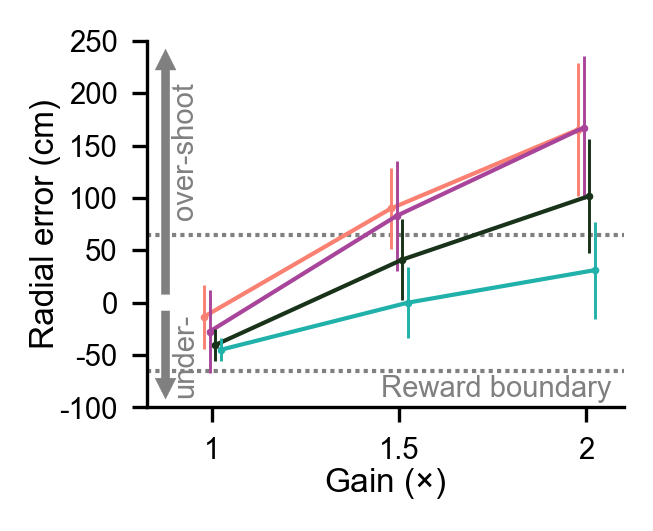

In [31]:
width = 2; height = 1.6
marker = '.'; marker_size = 5; marker_lw = lw * 0.7

xticklabels = [1, 1.5, 2]
xticks = np.arange(len(xticklabels))
yticks = np.arange(-100, 251, 50)
target_radius = arg.goal_radius_range[0] * 400

colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c]
dfs = [holistic_gain_trajectories_all_cat, moho_gain_trajectories_all_cat,
       homo_gain_trajectories_all_cat, modular_gain_trajectories_all_cat]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Gain ($\times$)', fontsize=fontsize + 1)
    ax.set_ylabel(r'Radial error (cm)', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.35, xticks[-1] + 0.2)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.16)
    ax.yaxis.set_label_coords(-0.18, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)

    xshifts = [-0.045, -0.015, 0.015, 0.045]        
    for agent_idx, dfs_ in enumerate(dfs):
        xdata = xticks + xshifts[agent_idx]
        ymean = np.vstack([df.relative_radius_end_shoot for df in dfs_]).mean(axis=1)
        ystd = np.std(np.vstack([df.relative_radius_end_shoot for df in dfs_]), axis=1)
        ax.scatter(xdata, ymean, c=colors[agent_idx], s=marker_size, lw=marker_lw, marker=marker)
        ax.plot(xdata, ymean, c=colors[agent_idx], lw=lw)
        ax.errorbar(xdata, ymean, ystd, c=colors[agent_idx], lw=marker_lw, ls='none') 
        
    ax.plot(np.linspace(*ax.get_xlim()), np.linspace(target_radius, target_radius), 
            ls=(0, (1, 1)), c='gray', lw=lw, zorder=-1)
    ax.plot(np.linspace(*ax.get_xlim()), -np.linspace(target_radius, target_radius), 
            ls=(0, (1, 1)), c='gray', lw=lw, zorder=-1, label='Reward boundary')
    
    arrow_x = 0.25
    ax.annotate("", xytext=(-arrow_x, 0), xy=(-arrow_x, ax.get_ylim()[0]),
                arrowprops=dict(arrowstyle="simple", lw=0.1, color='gray'))
    ax.annotate("", xytext=(-arrow_x, 0), xy=(-arrow_x, ax.get_ylim()[1]),
                arrowprops=dict(arrowstyle="simple", lw=0.1, color='gray'))
    ax.text(-arrow_x + 0.03, -85, s='under-', c='gray', rotation=90, fontsize=fontsize)
    ax.text(-arrow_x + 0.03, 85, s='over-shoot', c='gray', rotation=90, fontsize=fontsize)
    
        
    #ax.legend(fontsize=fontsize, frameon=False, loc=[0.1, 0.75], 
    #          handletextpad=0.6, labelspacing=0.22, ncol=1, columnspacing=0.5)
    ax.text(0.9, -90, 'Reward boundary', c='gray', fontsize=fontsize)
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))

    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='agent_error'), orientation='portrait', format='pdf', transparent=True)

## S4a

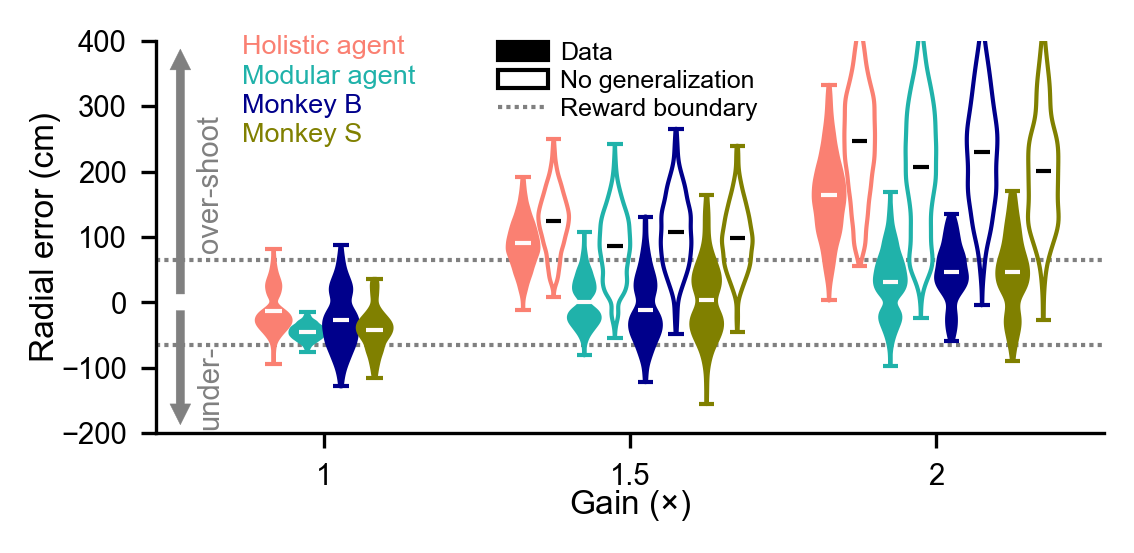

In [32]:
width = 3.6
height = 1.7
violin_width = 0.11

xticklabels = [1, 1.5, 2]
xticks = [1, 2, 3]
yticks = np.arange(-200, 401, 100)
target_radius = arg.goal_radius_range[0] * 400

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Gain $(\times)$', fontsize=fontsize + 1)
    ax.set_ylabel(r'Radial error (cm)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - 5 * violin_width, xticks[-1] + 5 * violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.14)
        
    # 1
    positions = [xticks[0] + i * violin_width for i in np.arange(-2, 3) + 0.5]
    dfs = [holistic_gain_trajectories_all_cat[0], modular_gain_trajectories_all_cat[0], 
           bruno_gain_trajectories[0], schro_gain_trajectories[0]]
    colors = [holistic_c, modular_c, monkB_c, monkS_c]
    for (idx, df), position, color in zip(enumerate(dfs), positions, colors):
        error = df.relative_radius_end_shoot
        vp = ax.violinplot(filter_fliers(error), positions=[position], widths=violin_width, showmeans=True)
        set_violin_plot(vp, facecolor=color, edgecolor=color)
        
    # 1.5, 2
    violin_width = 0.1
    positions = [xticks[1:3] + i * violin_width for i in np.arange(-5, 5) + 1.5]
    dfs = repeat_element(holistic_gain_trajectories_all_cat[1:], modular_gain_trajectories_all_cat[1:], 
                         bruno_gain_trajectories[1:], schro_gain_trajectories[1:])
    colors = repeat_element(holistic_c, modular_c, monkB_c, monkS_c)
    vps = []
    for (idx, df), position, color in zip(enumerate(dfs), positions, colors):
        error = [df_.relative_radius_end_shoot for df_ in df] if idx % 2 == 0\
                                                            else [df_.sim_relative_radius_end_shoot for df_ in df]
        vps.append(ax.violinplot(filter_fliers(error), positions=position, widths=violin_width, showmeans=True))
        facecolor = color if idx % 2  == 0 else 'None'
        set_violin_plot(vps[-1], facecolor=facecolor, edgecolor=color)
        
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    line1 = ax.plot(np.linspace(*ax.get_xlim()), np.linspace(target_radius, target_radius), 
                    ls=(0, (1, 1)), c='gray', lw=lw, zorder=-1)
    line2 = ax.plot(np.linspace(*ax.get_xlim()), -np.linspace(target_radius, target_radius), 
                    ls=(0, (1, 1)), c='gray', lw=lw, zorder=-1)
    
    arrow_x = 0.53
    ax.annotate("", xytext=(arrow_x, 0), xy=(arrow_x, ax.get_ylim()[0]),
                arrowprops=dict(arrowstyle="simple", lw=0.1, color='gray'))
    ax.annotate("", xytext=(arrow_x, 0), xy=(arrow_x, ax.get_ylim()[1]),
                arrowprops=dict(arrowstyle="simple", lw=0.1, color='gray'))
    ax.text(arrow_x + 0.05, -185, s='under-', c='gray', rotation=90, fontsize=fontsize)
    ax.text(arrow_x + 0.05, 85, s='over-shoot', c='gray', rotation=90, fontsize=fontsize)
    
    vps_ = []
    for _ in range(2):
        vps_.append(ax.violinplot([1000], widths=violin_width, showmeans=True))
        facecolor = 'k' if _ % 2  == 0 else 'None'
        set_violin_plot(vps_[-1], facecolor=facecolor, edgecolor='k')
        
    ax.legend([vp['bodies'][-1] for vp in vps_] + [line1[0]],
              ['Data', 'No generalization',
               'Reward boundary'], loc=[0.35, 0.77], frameon=False, fontsize=fontsize - 1, 
              ncol=1, columnspacing=0, handletextpad=0.5, labelspacing=0.2)
    
    xloc = 0.73; yloc = 380; ydiff = 45
    ax.text(xloc, yloc, s='Holistic agent', fontsize=fontsize - 0.5, c=holistic_c)
    ax.text(xloc, yloc - 1 * ydiff, s='Modular agent', fontsize=fontsize - 0.5, c=modular_c)
    ax.text(xloc, yloc - 2 * ydiff, s='Monkey B', fontsize=fontsize - 0.5, c=monkB_c)
    ax.text(xloc, yloc - 3 * ydiff, s='Monkey S', fontsize=fontsize - 0.5, c=monkS_c)
    
    plt.tight_layout(pad=0.2, rect=(0.01, 0, 1.01, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_radial_error'), orientation='portrait', format='pdf', transparent=True)

## 4e

In [33]:
dfs = [holistic_gain_trajectories_all, modular_gain_trajectories_all,
       moho_gain_trajectories_all, homo_gain_trajectories_all]

In [34]:
max_reward_boundary = int(max([df.relative_radius_end.max() for dfs_ in dfs for df_ in dfs_ for df in df_])) + 1 
hypo_reward_boundaries = np.arange(max_reward_boundary)

targets = modular_gain_trajectories[0][['target_x', 'target_y']].values
shuffled_targets = targets.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)

ydata_gain_agent = []; xdata_gain_agent = []; ysim_gain_agent = []; xsim_gain_agent = []
for dfs_ in dfs:
    ydata_gain = []; xdata_gain = []; ysim_gain = []; xsim_gain = []
    for idx in range(len(holistic_gain_trajectories_all)):
        df_ = dfs_[idx]
        ydata_ = []; xdata_ = []; ysim_ = []; xsim_ = []
        for df in df_:
            ydata = []; xdata = []; ysim = []; xsim = []
            for reward_boundary in hypo_reward_boundaries:
                ydata.append((np.linalg.norm(df[['pos_x_end', 'pos_y_end']] - targets, axis=1) 
                              < reward_boundary).sum() / len(df))
                xdata.append((np.linalg.norm(df[['pos_x_end', 'pos_y_end']] - shuffled_targets, axis=1) 
                              < reward_boundary).sum() / len(df))
                ysim.append((np.linalg.norm(df[['sim_pos_x_end', 'sim_pos_y_end']] - targets, axis=1) 
                             < reward_boundary).sum() / len(df))
                xsim.append((np.linalg.norm(df[['sim_pos_x_end', 'sim_pos_y_end']] - shuffled_targets, axis=1) 
                             < reward_boundary).sum() / len(df))
            ydata_.append(ydata); xdata_.append(xdata); ysim_.append(ysim); xsim_.append(xsim)  
        ydata_gain.append(ydata_)
        xdata_gain.append(xdata_)
        ysim_gain.append(ysim_)
        xsim_gain.append(xsim_)
        
    ydata_gain_agent.append(ydata_gain)
    xdata_gain_agent.append(xdata_gain)
    ysim_gain_agent.append(ysim_gain)
    xsim_gain_agent.append(xsim_gain)

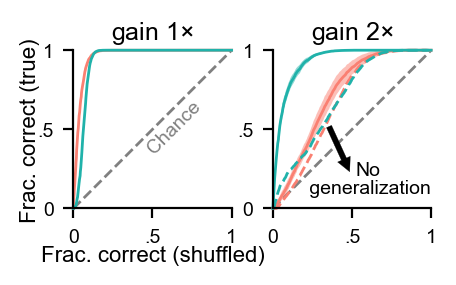

In [35]:
width = 2.1; height = 1.4
title_pad = 4

ticks = np.linspace(0, 1, 3)

titles = [fr'gain {i}$\times$' for i in [1, 2]]
colors = [holistic_c, modular_c]

with initiate_plot(width, height, 200) as fig:
    for (idx, f_idx), gain_idx in zip(enumerate(range(1, 3)), [0, 2]):
        ax = fig.add_subplot(1, 2, f_idx)
        ax.set_aspect('equal')
        ax.set_title(titles[idx], fontsize=fontsize + 2, pad=title_pad) 
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        plt.xticks(ticks, fontsize=fontsize)
        plt.yticks(ticks, fontsize=fontsize)
        ax.xaxis.set_major_formatter(major_formatter)
        ax.yaxis.set_major_formatter(major_formatter)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xlim([ticks[0], ticks[-1]])
        ax.set_ylim(ax.get_xlim())
        #ax.xaxis.set_label_coords(0.5, -0.1)

        for agent_idx in range(len(colors)):
            xmean = np.vstack(xdata_gain_agent[agent_idx][gain_idx]).mean(axis=0)
            ymean = np.vstack(ydata_gain_agent[agent_idx][gain_idx]).mean(axis=0)
            yerror = sem(np.vstack(ydata_gain_agent[agent_idx][gain_idx]), axis=0)

            ax.plot(xmean, ymean, c=colors[agent_idx], lw=lw, clip_on=False)
            ax.fill_between(xmean, ymean - yerror, ymean + yerror,
                            edgecolor='None', facecolor=colors[agent_idx], alpha=0.5)
            if idx != 0:
                xmean = np.vstack(xsim_gain_agent[agent_idx][gain_idx]).mean(axis=0)
                ymean = np.vstack(ysim_gain_agent[agent_idx][gain_idx]).mean(axis=0)
                ax.plot(xmean, ymean, c=colors[agent_idx], lw=lw, clip_on=False, ls='--')
        ax.plot(np.linspace(*ax.get_xlim()), np.linspace(*ax.get_ylim()), 
                c='gray', lw=lw, clip_on=False, ls='--', alpha=1, zorder=-1)

        if f_idx == 1:
            ax.set_xlabel('Frac. correct (shuffled)', fontsize=fontsize + 1)
            ax.set_ylabel('Frac. correct (true)', fontsize=fontsize + 1)
            ax.xaxis.set_label_coords(0.5, -0.23)
            ax.yaxis.set_label_coords(-0.21, 0.5)
            ax.text(0.45, 0.35, 'Chance', c='gray', fontsize=fontsize, rotation=45)
        elif f_idx == 2:
            ax.annotate("", xytext=(0.34, 0.55), xy=(0.5, 0.2),
                arrowprops=dict(arrowstyle="simple", lw=0.1, color='k'))
            ax.text(0.6, 0.1, 'No\n generalization', fontsize=fontsize, ha='center', linespacing=1)
    
    fig.tight_layout(pad=0.1, w_pad=-0, h_pad=0, rect=(0.005, 0, 1.005, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='ROC'), orientation='portrait', format='pdf', transparent=True)

## 4f

In [36]:
auc_data = [[[np.trapz(ydata_gain_agent[agent_idx][gain_idx][idx], xdata_gain_agent[agent_idx][gain_idx][idx])
              for idx in range(8)] for gain_idx in range(3)] for agent_idx in range(4)]
auc_sim = [[[np.trapz(ysim_gain_agent[agent_idx][gain_idx][idx], xsim_gain_agent[agent_idx][gain_idx][idx])
             for idx in range(8)] for gain_idx in range(3)] for agent_idx in range(4)]

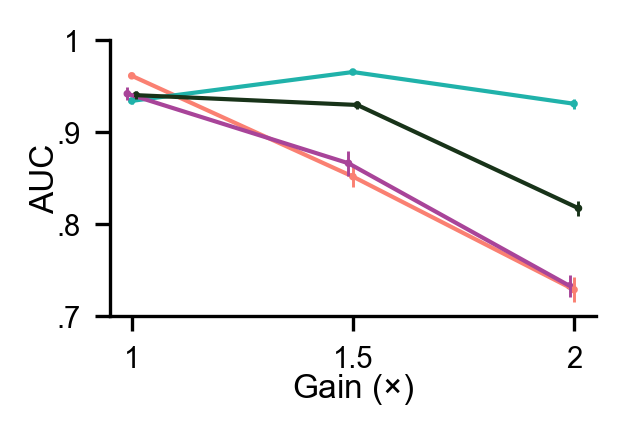

In [37]:
width = 1.9; height = 1.3
marker = '.'; marker_size = 5; marker_lw = lw * 0.7

yticks = np.around(np.linspace(0.7, 1, 4), 1)
xticks = np.arange(1, 4); xticklabels = [1, 1.5, 2]
colors = [holistic_c, modular_c, moact_hocri_c, hoact_mocri_c]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, xticklabels, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'Gain $(\times)$', fontsize=fontsize + 1)
    ax.set_ylabel('AUC', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0] - 0.1, xticks[-1] + 0.1)
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.2)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    #ax.xaxis.set_major_formatter(major_formatter)

    xshifts = [0, 0, -0.02, 0.02]   
    for agent_idx in range(len(colors)):
        xdata = xticks + xshifts[agent_idx]
        ymean = np.vstack(auc_data[agent_idx]).mean(axis=1)
        yerror = sem(np.vstack(auc_data[agent_idx]), axis=1)
        ax.scatter(xdata, ymean, edgecolors=colors[agent_idx], facecolors='none',
                   s=marker_size, lw=0.7, marker=marker)
        ax.plot(xdata, ymean, c=colors[agent_idx], lw=lw)
        ax.errorbar(xdata, ymean, yerror, c=colors[agent_idx], lw=marker_lw, ls='none')
        
    text_x = 1.05
    fig.tight_layout(pad=0.1, rect=(0, 0, 1, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #            name='AUC'), orientation='portrait', format='pdf', transparent=True)

## S4b

In [38]:
def compute_curvature(dfs, stack_trials=True):
    arg = config.ConfigCore()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        dfs = [dfs] if not isinstance(dfs, list) else dfs
        curvs = []
        for df in dfs:
            if 'gain_v' not in df.columns:
                linear_scale = 1
                df_ = df
                x_key = 'pos_x'; y_key = 'pos_y'
            else:
                if (df.gain_v > 100).any():  # monkey df
                    linear_scale = arg.LINEAR_SCALE
                    df_ = downsample(df)
                    x_key = 'pos_x_ds'; y_key = 'pos_y_ds'
                else:
                    linear_scale = 1
                    df_ = df
                    x_key = 'pos_x'; y_key = 'pos_y'

            curv = []
            for _, trial in df_.iterrows():
                dx = np.gradient(trial[x_key] * linear_scale); ddx = np.gradient(dx)
                dy = np.gradient(trial[y_key] * linear_scale); ddy = np.gradient(dy)
                curv_ = abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3 / 2)
                curv_ = curv_[(~np.isnan(curv_))]
                if curv_.size > 0:
                    curv_ = curv_[curv_ < np.percentile(curv_, 95)]
                else:
                    curv_ = np.array([np.nan])
                curv.append(curv_)

            curvs.append(np.hstack(curv)) if stack_trials else curvs.append(curv)
    return curvs

In [39]:
gain_idx = 1
curvatures_holistic = [compute_curvature(holistic_gain_trajectories_all[gain_idx][seed_idx], stack_trials=False) 
                       for seed_idx in range(len(holistic_gain_trajectories_all[gain_idx]))]
curvatures_moho = [compute_curvature(moho_gain_trajectories_all[gain_idx][seed_idx], stack_trials=False) 
                   for seed_idx in range(len(moho_gain_trajectories_all[gain_idx]))]
curvatures_homo = [compute_curvature(homo_gain_trajectories_all[gain_idx][seed_idx], stack_trials=False) 
                   for seed_idx in range(len(homo_gain_trajectories_all[gain_idx]))]
curvatures_modular = [compute_curvature(modular_gain_trajectories_all[gain_idx][seed_idx], stack_trials=False) 
                      for seed_idx in range(len(modular_gain_trajectories_all[gain_idx]))]

curvature_bruno = compute_curvature(bruno_gain_trajectories[gain_idx], stack_trials=False)[0]
curvature_schro = compute_curvature(schro_gain_trajectories[gain_idx], stack_trials=False)[0]

In [40]:
def get_curv_diff(agent_data, monkey_data=curvature_bruno):
    mean_curv_monkey = np.array([(trial).mean() for trial in monkey_data])
    curv_diff = []
    for agent_data_ in agent_data: # loop seeds
        mean_curv_agent = np.array([(trial).mean() for trial in agent_data_[0]])
        mask = ~(np.isnan(mean_curv_agent) | np.isnan(mean_curv_monkey))
        curv_diff.append(abs(mean_curv_agent - mean_curv_monkey)[mask])
        
    return np.hstack(curv_diff)

In [41]:
ydata = list(map(get_curv_diff, [curvatures_holistic, curvatures_moho, curvatures_homo, curvatures_modular, 
                                 [[curvature_schro]]], [curvature_bruno] * 5))

C:\Users\rz31\AppData\Local\Temp\ipykernel_12500\2354094407.py:2: RuntimeWarning: Mean of empty slice.
  mean_curv_monkey = np.array([(trial).mean() for trial in monkey_data])
C:\Users\rz31\AppData\Local\anaconda3\envs\inductivebiastest\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


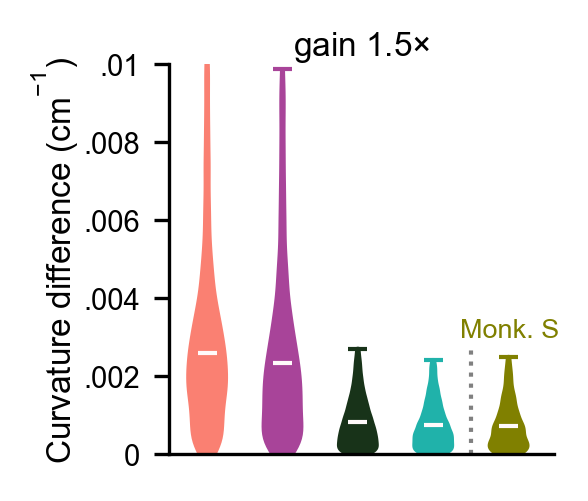

In [42]:
width = 1.8
height = 1.5
violin_width = 0.5

xticks = np.arange(5)
yticks = np.linspace(0, 0.01, 6)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title(r'gain 1.5$\times$', fontsize=fontsize + 1, pad=0)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Curvature difference (cm$^{-1}$)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + 1.2 * violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.23, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkS_c]
    for (idx, curv), color in zip(enumerate(ydata), colors):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(curv), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks([], fontsize=fontsize)
    ax.plot(np.linspace(3.5, 3.5), np.linspace(0, 0.0027), c='gray', ls=':', lw=lw) 
    ax.text(3.35, 0.003, 'Monk. S', fontsize=fontsize - 0.5, c=monkS_c)
    
    plt.tight_layout(pad=0.1)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='curvature_diff_1.5'), orientation='portrait', format='pdf', transparent=True)

In [43]:
gain_idx = 2
curvatures_holistic = [compute_curvature(holistic_gain_trajectories_all[gain_idx][seed_idx], stack_trials=False) 
                       for seed_idx in range(len(holistic_gain_trajectories_all[gain_idx]))]
curvatures_moho = [compute_curvature(moho_gain_trajectories_all[gain_idx][seed_idx], stack_trials=False) 
                   for seed_idx in range(len(moho_gain_trajectories_all[gain_idx]))]
curvatures_homo = [compute_curvature(homo_gain_trajectories_all[gain_idx][seed_idx], stack_trials=False) 
                   for seed_idx in range(len(homo_gain_trajectories_all[gain_idx]))]
curvatures_modular = [compute_curvature(modular_gain_trajectories_all[gain_idx][seed_idx], stack_trials=False) 
                      for seed_idx in range(len(modular_gain_trajectories_all[gain_idx]))]

curvature_bruno = compute_curvature(bruno_gain_trajectories[gain_idx], stack_trials=False)[0]
curvature_schro = compute_curvature(schro_gain_trajectories[gain_idx], stack_trials=False)[0]

In [44]:
ydata = list(map(get_curv_diff, [curvatures_holistic, curvatures_moho, curvatures_homo, curvatures_modular, 
                                 [[curvature_schro]]], [curvature_bruno] * 5))

C:\Users\rz31\AppData\Local\Temp\ipykernel_12500\2354094407.py:5: RuntimeWarning: Mean of empty slice.
  mean_curv_agent = np.array([(trial).mean() for trial in agent_data_[0]])
C:\Users\rz31\AppData\Local\anaconda3\envs\inductivebiastest\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


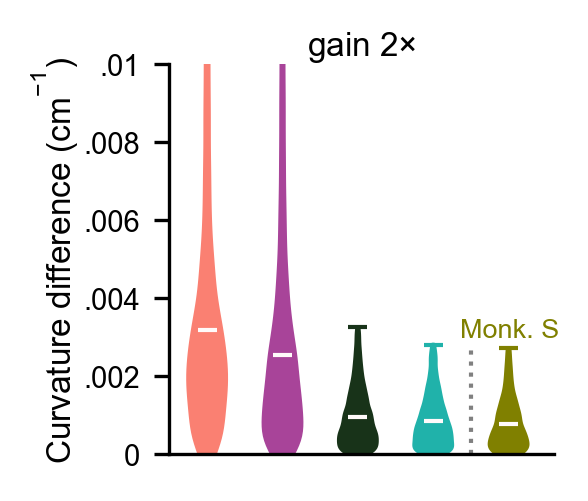

In [45]:
width = 1.8
height = 1.5
violin_width = 0.5

xticks = np.arange(5)
yticks = np.linspace(0, 0.01, 6)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title(r'gain 2$\times$', fontsize=fontsize + 1, pad=0)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Curvature difference (cm$^{-1}$)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + 1.2 * violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.23, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkS_c]
    for (idx, curv), color in zip(enumerate(ydata), colors):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(curv), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks([], fontsize=fontsize)
    ax.plot(np.linspace(3.5, 3.5), np.linspace(0, 0.0027), c='gray', ls=':', lw=lw) 
    ax.text(3.35, 0.003, 'Monk. S', fontsize=fontsize - 0.5, c=monkS_c)
    
    plt.tight_layout(pad=0.1)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='curvature_diff_2'), orientation='portrait', format='pdf', transparent=True)

## S4c

In [46]:
def compute_length(dfs):
    arg = config.ConfigCore()
    dfs = [dfs] if not isinstance(dfs, list) else dfs
    lengths = []
    for df in dfs:
        if 'gain_v' not in df.columns:
            linear_scale = 1
            df_ = df
            x_key = 'pos_x'; y_key = 'pos_y'
        else:
            if (df.gain_v > 100).any():  # monkey df
                linear_scale = arg.LINEAR_SCALE
                df_ = downsample(df)
                x_key = 'pos_x_ds'; y_key = 'pos_y_ds'
            else:
                linear_scale = 1
                df_ = df
                x_key = 'pos_x'; y_key = 'pos_y'

        length = []
        for _, trial in df_.iterrows():
            dx = np.diff(trial[x_key] * linear_scale)
            dy = np.diff(trial[y_key] * linear_scale)
            length.append((np.sqrt(dx**2 + dy**2)).sum())
        lengths.append(np.hstack(length))
    return lengths

In [47]:
gain_idx = 1
lengths_holistic = [compute_length(holistic_gain_trajectories_all[gain_idx][seed_idx]) 
                       for seed_idx in range(len(holistic_gain_trajectories_all[gain_idx]))]
lengths_moho = [compute_length(moho_gain_trajectories_all[gain_idx][seed_idx]) 
                   for seed_idx in range(len(moho_gain_trajectories_all[gain_idx]))]
lengths_homo = [compute_length(homo_gain_trajectories_all[gain_idx][seed_idx]) 
                   for seed_idx in range(len(homo_gain_trajectories_all[gain_idx]))]
lengths_modular = [compute_length(modular_gain_trajectories_all[gain_idx][seed_idx]) 
                      for seed_idx in range(len(modular_gain_trajectories_all[gain_idx]))]

length_bruno = compute_length(bruno_gain_trajectories[gain_idx])[0]
length_schro = compute_length(schro_gain_trajectories[gain_idx])[0]

In [48]:
def get_length_diff(agent_data, monkey_data=length_bruno, mask=bruno_normal_trajectory.rewarded):
    length_diff = []
    if len(agent_data) > 1:
        for agent_data_ in agent_data: # loop seeds
            length_agent = agent_data_[0]
            length_diff.append(abs(length_agent - monkey_data)[mask])
    else:
        length_diff.append(abs(agent_data[0][0] - monkey_data)[mask & schro_normal_trajectory.rewarded])
        
    return np.hstack(length_diff)

In [49]:
ydata = list(map(get_length_diff, [lengths_holistic, lengths_moho, lengths_homo, lengths_modular, [[length_schro]]],
                 [length_bruno] * 5, [bruno_normal_trajectory.rewarded] * 5))

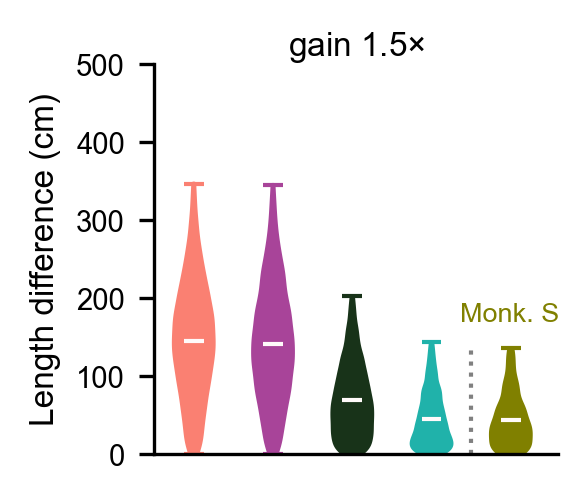

In [50]:
width = 1.8
height = 1.5
violin_width = 0.5

xticks = np.arange(5)
yticks = np.arange(0, 501, 100)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title(r'gain 1.5$\times$', fontsize=fontsize + 1, pad=0)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Length difference (cm)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + 1.2 * violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.23, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkS_c]
    for (idx, leng), color in zip(enumerate(ydata), colors):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(leng), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks([], fontsize=fontsize)
    ax.plot(np.linspace(3.5, 3.5), np.linspace(0, 140), c='gray', ls=':', lw=lw) 
    ax.text(3.98, 170, 'Monk. S', ha='center', fontsize=fontsize - 0.5, c=monkS_c)
    
    plt.tight_layout(pad=0.1)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='length_diff_1.5'), orientation='portrait', format='pdf', transparent=True)

In [51]:
gain_idx = 2
lengths_holistic = [compute_length(holistic_gain_trajectories_all[gain_idx][seed_idx]) 
                       for seed_idx in range(len(holistic_gain_trajectories_all[gain_idx]))]
lengths_moho = [compute_length(moho_gain_trajectories_all[gain_idx][seed_idx]) 
                   for seed_idx in range(len(moho_gain_trajectories_all[gain_idx]))]
lengths_homo = [compute_length(homo_gain_trajectories_all[gain_idx][seed_idx]) 
                   for seed_idx in range(len(homo_gain_trajectories_all[gain_idx]))]
lengths_modular = [compute_length(modular_gain_trajectories_all[gain_idx][seed_idx]) 
                      for seed_idx in range(len(modular_gain_trajectories_all[gain_idx]))]

length_bruno = compute_length(bruno_gain_trajectories[gain_idx])[0]
length_schro = compute_length(schro_gain_trajectories[gain_idx])[0]

In [52]:
ydata = list(map(get_length_diff, [lengths_holistic, lengths_moho, lengths_homo, lengths_modular, [[length_schro]]],
                 [length_bruno] * 5, [bruno_normal_trajectory.rewarded] * 5))

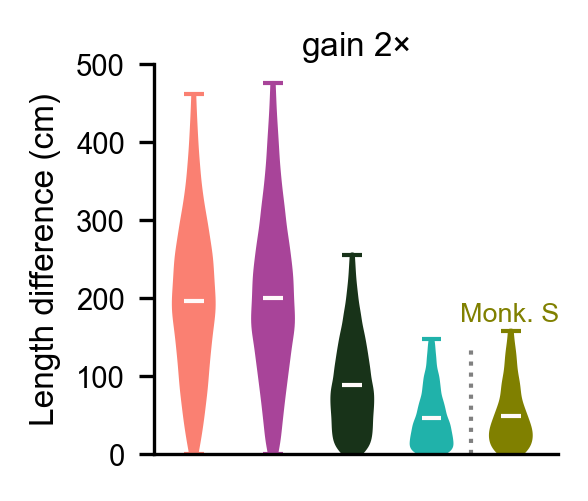

In [53]:
width = 1.8
height = 1.5
violin_width = 0.5

xticks = np.arange(5)
yticks = np.arange(0, 501, 100)

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title(r'gain 2$\times$', fontsize=fontsize + 1, pad=0)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel(r'', fontsize=fontsize + 1)
    ax.set_ylabel(r'Length difference (cm)', fontsize=fontsize + 1)
    ax.set_xlim([xticks[0] - violin_width, xticks[-1] + 1.2 * violin_width]); 
    ax.set_ylim([yticks[0], yticks[-1]])
    ax.yaxis.set_label_coords(-0.23, 0.5)
    ax.yaxis.set_major_formatter(major_formatter)
    
    colors = [holistic_c, moact_hocri_c, hoact_mocri_c, modular_c, monkS_c]
    for (idx, leng), color in zip(enumerate(ydata), colors):
        locals()[f'vp{idx}'] = ax.violinplot(filter_fliers(leng), 
                                             positions=[idx], widths=violin_width, showmeans=True)
        set_violin_plot(locals()[f'vp{idx}'], facecolor=color, edgecolor=color)
        
    plt.xticks([], fontsize=fontsize)
    ax.plot(np.linspace(3.5, 3.5), np.linspace(0, 140), c='gray', ls=':', lw=lw) 
    ax.text(3.98, 170, 'Monk. S', ha='center', fontsize=fontsize - 0.5, c=monkS_c)
    
    plt.tight_layout(pad=0.1)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='length_diff_2'), orientation='portrait', format='pdf', transparent=True)